In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error,confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [18]:
filepath_train = os.getcwd() + "/Group20/Classification/Image_Group20/trainBOVW.csv"
filepath_test = os.getcwd() + "/Group20/Classification/Image_Group20/testBOVW.csv"

train = pd.read_csv(filepath_train)
test = pd.read_csv(filepath_test)

X_train = train.iloc[:,:-1].to_numpy()
Y_train = train.iloc[:,-1].to_numpy()

X_val = test.iloc[:,:-1].to_numpy()
Y_val = test.iloc[:,-1].to_numpy()

#data=np.loadtxt(filepath)
#print(data)
#print(data.shape)

In [19]:
#one hot encoder
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
#print(y_OH_train.shape, y_OH_val.shape)

In [20]:
class FFSN_MultiClass:
  
  def __init__(self, n_inputs, n_outputs, hidden_sizes=[4,3]):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny] 

    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)

  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]
  
  def predict(self, X,plot=False):
    Y_pred = []
    if plot==True:
        fig = plt.figure(figsize=(15,15))
        ax1 = fig.add_subplot(421, projection='3d')
        ax2 = fig.add_subplot(422, projection='3d')
        ax3 = fig.add_subplot(423, projection='3d')
        ax4 = fig.add_subplot(424, projection='3d')
        ax5 = fig.add_subplot(425, projection='3d')
        ax6 = fig.add_subplot(426, projection='3d')
        ax7 = fig.add_subplot(427, projection='3d')
        for x in X:
          y_pred = self.forward_pass(x)
          Y_pred.append(y_pred)
          ax1.scatter(x[0], x[1], self.H[1][0][0])
          ax2.scatter(x[0], x[1], self.H[1][0][1])
          ax3.scatter(x[0], x[1], self.H[1][0][2])
          ax4.scatter(x[0], x[1], self.H[1][0][3])
          ax5.scatter(x[0], x[1], self.H[2][0][0])
          ax6.scatter(x[0], x[1], self.H[2][0][1])
          ax7.scatter(x[0], x[1], self.H[2][0][2])
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('output')
        ax1.set_title('Hidden Node1_Layer1')
        
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('output')
        ax2.set_title('Hidden Node2_Layer1')
        
        ax3.set_xlabel('X')
        ax3.set_ylabel('Y')
        ax3.set_zlabel('output')
        ax3.set_title('Hidden Node3_Layer1')
        
        ax4.set_xlabel('X')
        ax4.set_ylabel('Y')
        ax4.set_zlabel('output')
        ax4.set_title('Hidden Node4_Layer1')
        
        ax5.set_xlabel('X')
        ax5.set_ylabel('Y')
        ax5.set_zlabel('output')
        ax5.set_title('Hidden Node1_Layer2')
        
        ax6.set_xlabel('X')
        ax6.set_ylabel('Y')
        ax6.set_zlabel('output')
        ax6.set_title('Hidden Node2_Layer2')
        
        ax7.set_xlabel('X')
        ax7.set_ylabel('Y')
        ax7.set_zlabel('output')
        ax7.set_title('Hidden Node3_Layer2')
        
        plt.show()
    else:
        for x in X:
          y_pred = self.forward_pass(x)
          Y_pred.append(y_pred)       
    return np.array(Y_pred).squeeze()
 
  def grad_sigmoid(self, x):
    return x*(1-x) 
  
  def cross_entropy(self,label,pred):
    yl=np.multiply(pred,label)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl
 
  def grad(self, x, y): #back propagation
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1])) 
    
  def fit(self, X, Y, epochs=100, initialize='True', learning_rate=0.01, display_loss=False):
      
    if display_loss:
      loss = {}
      
    if initialize:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
    
    for epoch in (range(epochs)): 
      #print(epoch)
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X, Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
                  
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * (dW[i+1]/m)
        self.B[i+1] -= learning_rate * (dB[i+1]/m)
        
      if display_loss:
        Y_pred = self.predict(X) 
        loss[epoch] = self.cross_entropy(Y, Y_pred)/len(X)
     
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('Average Error')
      plt.show()

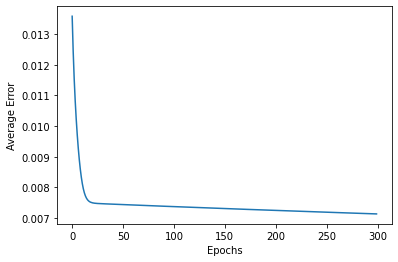

In [21]:
#train the network
ffsn_multi = FFSN_MultiClass(32,3,[38,36])
ffsn_multi.fit(X_train,y_OH_train,epochs=300,learning_rate=.005,display_loss=True)
# ffsn_multi.fit(X_train,Y_train,epochs=2000,learning_rate=.005,display_loss=True)

In [22]:
Y_pred_train = ffsn_multi.predict(X_train)
Y_pred_train = np.argmax(Y_pred_train,1)

In [23]:
Y_pred_val = ffsn_multi.predict(X_val)
Y_pred_val = np.argmax(Y_pred_val,1)

In [24]:
accuracy_train = accuracy_score(Y_pred_train, Y_train)
accuracy_val = accuracy_score(Y_pred_val[:len(Y_val)//2], Y_val[:len(Y_val)//2])
accuracy_test = accuracy_score(Y_pred_val[len(Y_val)//2:], Y_val[len(Y_val)//2:])

print("Training accuracy", 100*round(accuracy_train, 4))
print("Validation accuracy", 100*round(accuracy_val, 4))
print("Test accuracy ", 100*round(accuracy_test, 4))

Training accuracy 48.0
Validation accuracy 37.330000000000005
Test accuracy  57.330000000000005


In [25]:
 print(confusion_matrix(Y_pred_val[len(Y_val)//2:], Y_val[len(Y_val)//2:]))

[[ 0  4  1]
 [ 0 10 16]
 [ 0 11 33]]


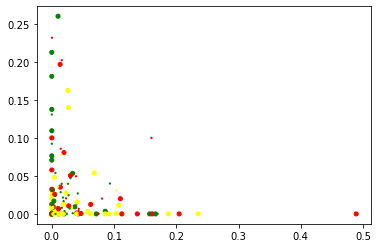

In [26]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])
#visualize
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
plt.show()